In [55]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

## From Guillaume

### Initial conditions

In [56]:

"""Symbols"""
theta1, theta2, theta1_dot, theta2_dot, theta1_ddot, theta2_ddot = sp.symbols('theta1 theta2 theta1_dot theta2_dot, theta1_ddot, theta2_ddot')

"""Parameters"""
m1, m2, l1, l2 = 1, 1, 1, 1 # Masses and lengths
g = 9.81    # Gravitational acceleration
y0 = np.array([np.pi/2, np.pi/2, 0, 0]) # Initial conditions

"""Temporal path"""
T = 2.0     # Total time
N = 1000    # Number of time steps
h = T / N   # Temporal path

"""Equations"""
eq1 = (m1 + m2) * l1 * theta1_ddot + m2 * l2 * theta2_ddot * sp.cos(theta1 - theta2) + m2 * l2 * theta2_dot**2 * sp.sin(theta1 - theta2) + (m1 + m2) * 9.81 * sp.sin(theta1)
eq2 = l1 * theta1_ddot * sp.cos(theta1 - theta2) + l2 * theta2_ddot - l1 * theta1_dot**2 * sp.sin(theta1 - theta2) + 9.81 * sp.sin(theta2)


### Resolving the system

In [57]:
"""Resolution of the system"""
sys = sp.solve((eq1,eq2),(theta1_ddot,theta2_ddot), dict = True)[0]
theta1_ddot_ = sp.simplify(sys[theta1_ddot])
theta2_ddot_ = sp.simplify(sys[theta2_ddot])

"""Substitution"""
theta1_ddot_lambdify = sp.lambdify((theta1, theta1_dot, theta2, theta2_dot), theta1_ddot_, 'numpy')
theta2_ddot_lambdify = sp.lambdify((theta1, theta1_dot, theta2, theta2_dot), theta2_ddot_, 'numpy')

### Function F

In [58]:
def F(t, y):
    return np.array([y[2], y[3], theta1_ddot_lambdify(y[0], y[1], y[2], y[3]), theta2_ddot_lambdify(y[0], y[1], y[2], y[3])])

## Verlet method

In [59]:
def verlet(Y0, h, l1, l2, m1, m2, N = 1000, g = 9.81):
    """
    Y0: initial conditions
    h: temporal path
    l1: length of the first pendulum
    l2: length of the second pendulum
    m1: mass of the first pendulum
    m2: mass of the second pendulum
    N: number of time steps
    g: gravitational acceleration
    """
    # Initialize an array to store the state vectors at each time step
    Y = np.zeros((N+1, 4))
    # Set the initial condition
    Y[0, :] = Y0
    # Compute the derivative vector at the initial state using function F
    # Initial derivative
    F_Y = F(0, Y0)
    # First step using Euler to bootstrap Verlet
    Y[1, :] = Y[0, :] + h * F_Y + 0.5 * h**2 * F_Y

    # Iterate over each time step
    for i in range(1, N):
        # Compute the derivative vector at the current state using function F
        y_temp = np.zeros(4)
        y_temp[:2] = 2 * Y[i, :2] - Y[i-1, :2] + (h**2) * F(0,Y[i, :])[2:] # Verlet method
        y_temp[2:] = (y_temp[:2] - Y[i-1, :2]) / (2 * h) 
        # Updating Y[i+1] using intermediate values
        Y[i+1, :2] = y_temp[:2] 
        Y[i+1, 2:] = (Y[i+1, :2] - Y[i, :2]) / h # Derivative

    return Y

## Printing part

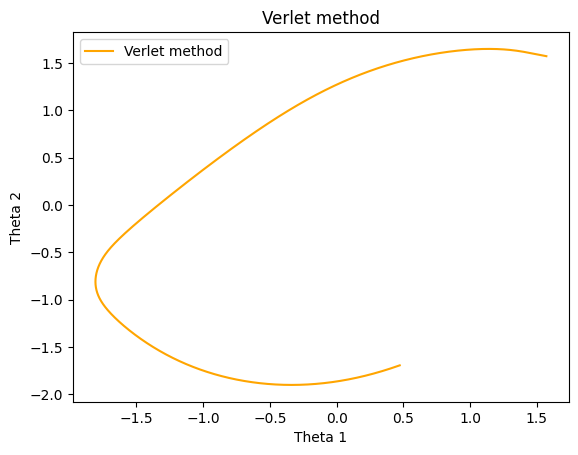

In [60]:
Y = verlet(y0, h, l1, l2, m1, m2, N, g)
plt.plot(Y[:, 0], Y[:, 1], label = 'Verlet method', color = 'orange')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.title('Verlet method')
plt.legend()
plt.show()
